Щепалов Корней Павлович
Цель исследования: показать как выглядить путь клиента от знакомства с продуктом до его получения. Определние проблемных мест.
Для начала попробуем отследить динамику по месяцам.

In [1]:
!pip3 install psycopg2-binary

SyntaxError: invalid syntax (2894785589.py, line 2)

In [2]:
!pip3 install kaleido

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 65.9/65.9 MB 8.8 MB/s eta 0:00:00


In [6]:
import psycopg2
import pandas as pd
import plotly.io as pio
import kaleido

In [7]:
# Подкючаюсь к базе
conn = psycopg2.connect(
 host="158.160.52.106",
 port=5432,
 database="postgres",
 user="student",
 password="JvLda93aA",
)
cur = conn.cursor()


In [8]:
# Получаю количество клиентов которые посетили сайт по месяцам.
vis = pd.read_sql(
    '''select EXTRACT(month from visit_dttm) as months, count(visit_dttm) 
       from msu_analytics.client 
       group by months
       order by months''', conn)
vis.head()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,months,count
0,1.0,852
1,2.0,32
2,9.0,778
3,10.0,843
4,11.0,786


In [9]:
# Количество зарегестрировавшихся клиентов
regs = pd.read_sql(
    '''select EXTRACT(month from registration_dttm) as months, count(registration_dttm) 
       from msu_analytics.account 
       group by months 
       order by months''', conn)
regs.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,months,count
0,1.0,215
1,2.0,9
2,9.0,186
3,10.0,219
4,11.0,195


In [10]:
# Количество клиентов, которые подали заявку на игру
applic = pd.read_sql(
    '''select EXTRACT(month from application_dttm) as months, count(application_dttm) 
       from msu_analytics.application 
       group by months 
       order by months''',
    conn)
applic.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,months,count
0,1.0,133
1,2.0,3
2,9.0,63
3,10.0,109
4,11.0,107


In [11]:
# Количество игр
games = pd.read_sql(
    '''with test_table as 
       (select * from msu_analytics.game where game_flg = 1)

       select extract(month from game_dttm) as months, count(game_dttm) from test_table group by months order by months''', conn)
games.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,months,count
0,1.0,63
1,2.0,3
2,9.0,2
3,10.0,21
4,11.0,43


In [12]:
# Для удобства объединим все в одну таблицу

data = vis.merge(regs, left_on='months', right_on='months', how = 'inner')
data = data.merge(applic, left_on='months', right_on='months', how = 'inner')
data = data.merge(games, left_on='months', right_on='months', how = 'inner')
data.set_index('months', inplace = True)
listed = data.T
listed

C:\Users\delux\AppData\Local\Temp\ipykernel_17888\4014729291.py:5: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'count_x'} in the result is deprecated and will raise a MergeError in a future version.



months,1.0,2.0,9.0,10.0,11.0,12.0
count_x,852,32,778,843,786,805
count_y,215,9,186,219,195,200
count_x,133,3,63,109,107,97
count_y,63,3,2,21,43,47


In [13]:
total = []
listed.rename(columns = {1.0:'Январь', 2.0:'Февраль', 9.0: "Сентябрь", 10.0:"Октябрь", 11.0: "Ноябрь", 12.0: "Декабрь"}, inplace = True )
for column in listed.columns:
    total.extend(listed[column].tolist())

listed

months,Январь,Февраль,Сентябрь,Октябрь,Ноябрь,Декабрь
count_x,852,32,778,843,786,805
count_y,215,9,186,219,195,200
count_x,133,3,63,109,107,97
count_y,63,3,2,21,43,47


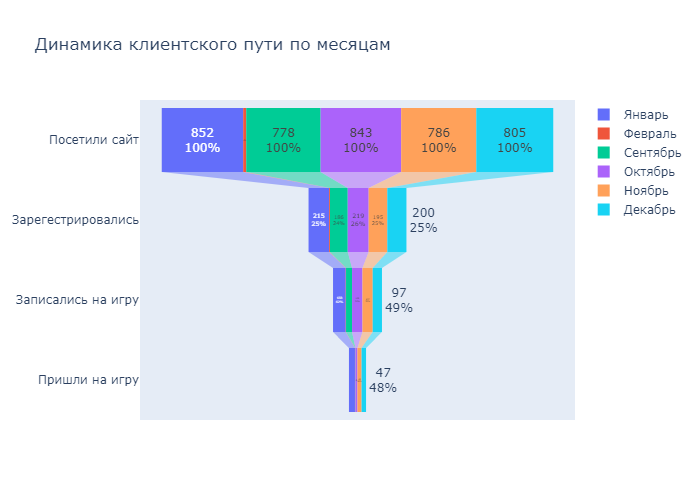

In [14]:
import plotly.graph_objects as go
fig = go.Figure()

for column in listed.columns:
    values = (listed[column].tolist())
    
    fig.add_trace(go.Funnel(
        y=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
        x=values, textinfo='value+percent previous', 
        name = column,
        ))
fig.update_layout(title="Динамика клиентского пути по месяцам")

fig.show('png')

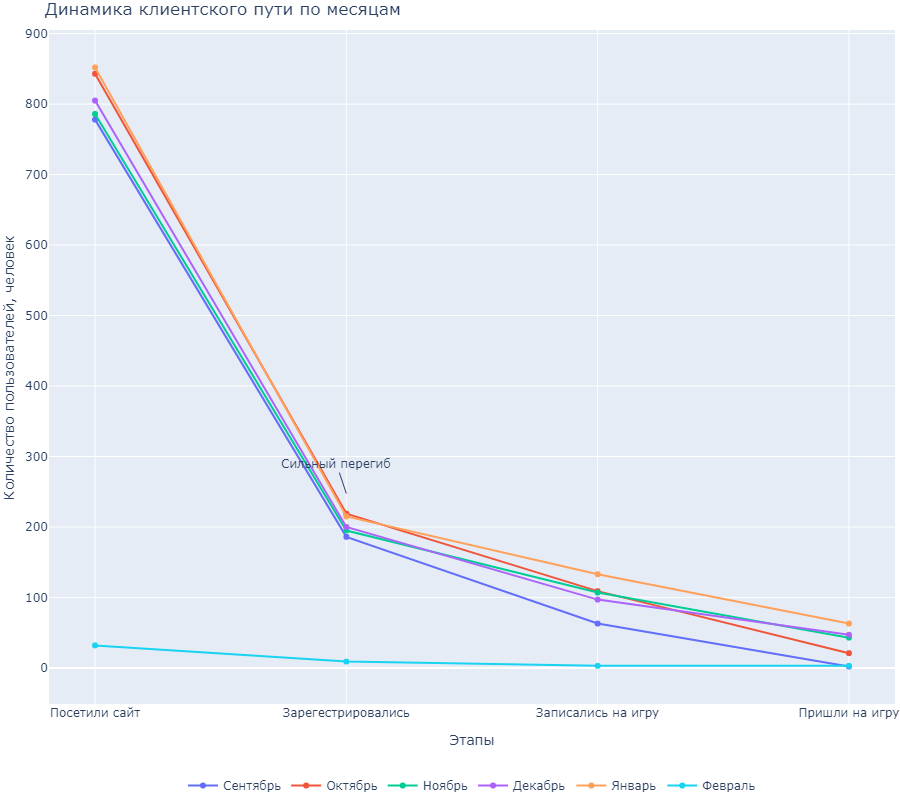

In [15]:
# Попробуем другой вид диаграммы.

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[778,186,63,2], name = 'Сентябрь'
))

fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[843,219,109,21], name = 'Октябрь'
    
    
))

fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[786,195,107,43], name = 'Ноябрь'
    
    
))

fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[805,200,97,47], name = 'Декабрь'
    
    
))


fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[852, 215, 133, 63], name = 'Январь'
    
    
))

fig.add_trace(go.Scatter(
    x=['Посетили сайт', 'Зарегестрировались', 'Записались на игру', 'Пришли на игру'],
    y=[32, 9, 3, 3], name = 'Февраль'
    
    
))

    
fig.add_annotation(x='Зарегестрировались', y=219,
            text="Сильный перегиб",
            showarrow=True,
            yshift=20,
            xshift = 0)

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Динамика клиентского пути по месяцам",
                  xaxis_title="Этапы",
                  yaxis_title="Количество пользователей, человек",
                  margin=dict(l=1, r=0, t=30, b=0),
                    height=800,
                  width=900)

fig.show('png')
# Достаточно читаемо.

In [17]:
# Получаю количество клиентов которые посетили сайт.
vis_w = pd.read_sql(
    '''select EXTRACT(week from visit_dttm) as weeks, count(visit_dttm) as cnt_vis
       from msu_analytics.client 
       group by weeks
       order by weeks''', conn)
vis_w.set_index('weeks', inplace = True)

vis_w

# msu_analytics


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,cnt_vis
weeks,
1.0,201
2.0,205
3.0,181
4.0,182
5.0,81
35.0,111
36.0,184
37.0,167
38.0,181


In [18]:
# Количество зарегестрировавшихся клиентов
regs_w = pd.read_sql(
    '''select EXTRACT(week from registration_dttm) as weeks, count(registration_dttm) as cnt_regs 
       from msu_analytics.account 
       group by weeks 
       order by weeks''', conn)

regs_w.set_index('weeks', inplace = True)
regs_w

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,cnt_regs
weeks,
1.0,55
2.0,54
3.0,42
4.0,40
5.0,26
35.0,22
36.0,38
37.0,42
38.0,46


In [19]:
# Количество клиентов, которые подали заявку на игру
applic_w = pd.read_sql(
    '''select EXTRACT(week from application_dttm) as weeks, count(application_dttm) as cnt_app 
       from msu_analytics.application 
       group by weeks 
       order by weeks''',
    conn)
applic_w.set_index('weeks', inplace = True)
applic_w

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,cnt_app
weeks,
1.0,24
2.0,23
3.0,40
4.0,33
5.0,11
36.0,7
37.0,17
38.0,24
39.0,18


In [20]:
# Количество игр
games_w = pd.read_sql(
    '''with test_table as 
       (select * from msu_analytics.game where game_flg = 1)

       select extract(week from game_dttm) as weeks, count(game_dttm) as cnt_games from test_table group by weeks order by weeks''', conn)
games_w.set_index('weeks', inplace = True)
games_w

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,cnt_games
weeks,
1.0,16
2.0,8
3.0,15
4.0,17
5.0,9
37.0,1
38.0,1
39.0,1
40.0,5


In [21]:
# Для удобства объединим все в одну таблицу

data = vis_w.merge(regs_w, left_on='weeks', right_on='weeks', how = 'inner')
data = data.merge(applic_w, left_on='weeks', right_on='weeks', how = 'inner')
data = data.merge(games_w, left_on='weeks', right_on='weeks', how = 'inner')

data

,cnt_vis,cnt_regs,cnt_app,cnt_games
weeks,,,,
1.0,201,55,24,16
2.0,205,54,23,8
3.0,181,42,40,15
4.0,182,40,33,17
5.0,81,26,11,9
37.0,167,42,17,1
38.0,181,46,24,1
39.0,195,56,18,1
40.0,204,59,33,5


In [22]:
# Проведу некоторые операции с обозначением недель
index_list = data.index.values.tolist()
for i in range(5):
    index_list.pop(0)
    index_list.append(float(i+1))

weeks = list(map(int, index_list))
weeks = list(map(str, weeks))
weeks


['37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '1',
 '2',
 '3',
 '4',
 '5']

In [23]:
raws_f = data.loc[:5]
raws_l = data.loc[6:]
df = raws_l.append(raws_f)
df.rename(columns = {'cnt_vis':'Посещения сайта', 'cnt_regs':'Регистрация клиентов', 'cnt_app': "Подали заявку на игру",'cnt_games':"Игра состоялась"}, inplace = True )
df

C:\Users\delux\AppData\Local\Temp\ipykernel_17888\2199604937.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Посещения сайта,Регистрация клиентов,Подали заявку на игру,Игра состоялась
weeks,,,,
37.0,167,42,17,1
38.0,181,46,24,1
39.0,195,56,18,1
40.0,204,59,33,5
41.0,190,46,28,3
42.0,171,42,24,5
43.0,189,48,18,7
44.0,197,46,25,8
45.0,173,43,30,10


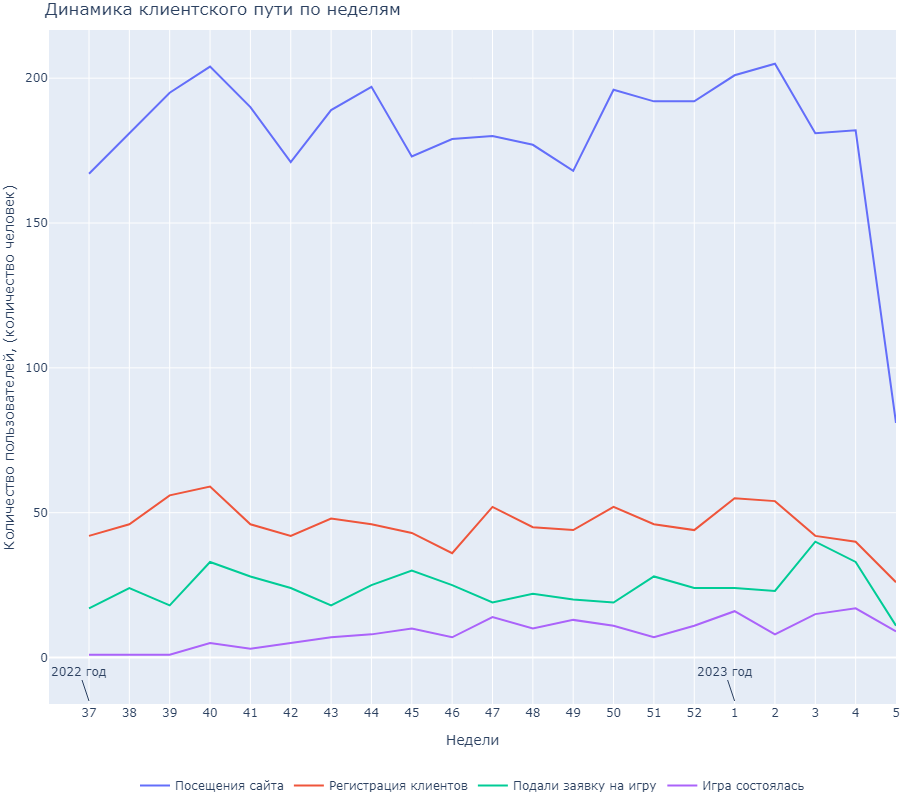

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
for column in df.columns:
    values = df[column].tolist()
    fig.add_trace(go.Scatter(
        x=weeks,
        y=values, name = column
        ))

    
fig.add_annotation(x='16', y=-15,
            text="2023 год",
            showarrow=True,
            yshift=0,
            xshift = 0)

fig.add_annotation(x='0', y=-15,
            text="2022 год",
            showarrow=True,
            yshift=0,
            xshift =0)

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Динамика клиентского пути по неделям",
                  xaxis_title="Недели",
                  yaxis_title="Количество пользователей, (количество человек)",
                  margin=dict(l=1, r=0, t=30, b=0),
                    height=800,
                  width=900)

fig.show('png')
# Достаточно читаемо.

Выводы: 
    Потеря клиентов на каждом этапе неизбежна, однако их количество можно сократить. На этапе регистрации теряется ~75% клиентов, что явяется самым маленьким показателем конверсии для динамики по месяцам и неделям (25%). На остальных этапах теряется около половины клиентов (конверсия составляет ~50%).
    Скорее всего проблема в трудности регистрации или незаинтересованности клиентов. Я могу предложить упросить процесс регистрации или для новых зарегестрированных пользователей добавить какие-нибудь подарки, по типу персональной скидки или бонусов. Но скидка будет действительна при подаче заявки на игру в течение первой недели регистрации. Таким образом можно будет увеличить показатель конверсии сразу для двух этап клиентовского пути.